In [1]:
# inline plotting instead of popping out
%matplotlib inline

import os
from IPython.display import Image
from IPython.display import display
import numpy as np
import pandas as pd
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from cycler import cycler

import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

### Data Analysis

In [11]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [12]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))
print('class label: ', np.unique(data[len(data.columns)-1]))

452 rows and 280 columns
class label:  [ 1  2  3  4  5  6  7  8  9 10 14 15 16]


Let's make that column (class label) dichotomous. \
Value is 0 if ECG is normal, 1 otherwise

In [13]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [17]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

Some columns have missing values denoted as '?' \
To make the preprocessing simpler, let's just retain the columns with numeric values

In [19]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

data.head(3)

452 rows and 275 columns


,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [22]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print("CLASS LABEL:", np.unique(y))
print(X.shape)

CLASS LABEL: [0 1]
(452, 274)


In [24]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [26]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### LogisticRegression Implementation

In [47]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate loss"""
        # TODO
        #Ref : https://github.com/SagarGhiya7/Implementing-Logistic-Regression-from-Scratch-in-Python/blob/master/SML_HWK3_Logistic.ipynb
        #Ref : https://medium.com/@ken90242/machine-learning%E5%AD%B8%E7%BF%92%E6%97%A5%E8%A8%98-coursera%E7%AF%87-week-3-2-cost-2e7aa00e8c4a
        a_ = y * np.log(output)
        b_ = (1-y) * np.log(1-output)
        cost = -(1/len(output)) * np.sum(a_ + b_)
        return cost
        
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        # TODO
        return 1.0 / (1.0 + np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        # TODO
        net_input = self.net_input(X)
        pred = self.activation(net_input)
        #print("net_input", net_input, net_input.shape)
        #print("predict", pred, pred.shape)
        #result = pd.DataFrame(net_input)
        result2 = pd.DataFrame(pred)
        #print(result2)
        out = result2[0].apply(lambda x: 0 if x < 1 else 1)
        #print(out)
        return out

In [48]:
lr = LogisticRegression(n_epoch=500)

lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


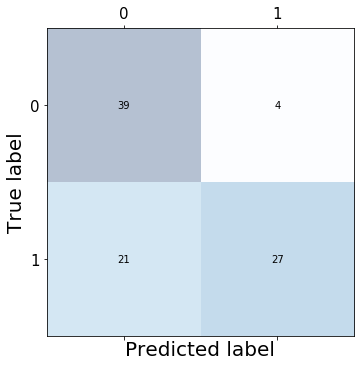

In [49]:
# plot confusion matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-confusion.png', dpi=300)
plt.show()

In [50]:
print('\n[F1-score]')
f = f1_score(y_true=y_test, y_pred=y_pred, average=None)
print('Individual: %.2f' % (f[0]) )


[F1-score]
Individual: 0.76
